# Divisive Clustering With Coresets Using CUDA-Q

This tutorial explores a CUDA-Q implementation of recent research conducted by a team from the University of Edinburgh (ArXiv Paper: [https://arxiv.org/pdf/2402.01529.pdf](https://arxiv.org/pdf/2402.01529.pdf)). Developed jointly by NVIDIA and the authors, this tutorial aims to help users understand their method and demonstrate how CUDA-Q facilitates scaling.

The code for this tutorial is based on the MIT licensed code available here: [https://github.com/Boniface316/bigdata_vqa](https://github.com/Boniface316/bigdata_vqa).

Clustering is a common unsupervised learning technique that groups data with similar characteristics. Quantum computers' unique properties could enhance pattern finding in clustering applications and enable more reliable data analysis. However, current quantum computers are limited by qubit count and noise, making practical clustering applications challenging. The Edinburgh team developed a new method (extending Harrow's work) to leverage coresets for clustering applications on quantum computers, using far fewer qubits. This tutorial demonstrates this approach for divisive clustering and highlights the utility of CUDA-Q for scaling quantum simulations.

Divisive clustering starts with all data points as one set and iteratively bipartitions the data until each point forms its own cluster. This branching process helps understand similarities among data points.

In [1]:
# If you are running outside of a CUDA-Q container or CUDA-Q directory tree, you may need to uncomment these lines to fetch the files.
# If you are running inside a CUDA-Q tree, then this step can be skipped.
!mkdir divisive_clustering_src
!wget -P divisive_clustering_src https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/divisive_clustering.py
!wget -P divisive_clustering_src https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/main_divisive_clustering.py

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2024-11-16 23:05:45--  https://raw.githubusercontent.com/NVIDIA/cuda-quantum/main/docs/sphinx/applications/python/divisive_clustering_src/divisive_clustering.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44575 (44K) [text/plain]
Saving to: ‘divisive_clustering_src/divisive_clustering.py’

divisive_clustering 100%[===================>]  43.53K  --.-KB/s    in 0.01s   

2024-11-16 23:05:45 (4.38 MB/s) - ‘divisive_clustering_src/divisive_clustering.py’ saved [44575/44575]

/bin/bash: /home/ryuki

In [1]:
# Install the relevant packages.
!pip install mpi4py==3.1.6 networkx==2.8.8 pandas==2.2.2 scikit-learn==1.4.2 tqdm==4.66.2 -q

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import cudaq
from cudaq import spin

# Auxillary Imports
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from typing import Tuple
from divisive_clustering_src.divisive_clustering import Coreset, DivisiveClustering, Dendrogram, Voironi_Tessalation

warnings.filterwarnings("ignore")

In [3]:
circuit_depth = 1
max_iterations = 75
max_shots = 1000
np.random.seed(10)

Given a dataset \( D \), a coreset is a weighted dataset of much smaller size (\( D' \)) that represents \( D \) well enough such that analysis of \( D' \) can allow us to draw reasonable approximate conclusions about \( D \). Various approaches to build coresets can be found in the papers [Practical Coreset Construction for Machine Learning](https://arxiv.org/pdf/1703.06476.pdf) and [New Streaming Algorithms for Coresets in Machine Learning](https://arxiv.org/pdf/1703.06476.pdf).

Essentially, coreset construction involves finding the optimal coreset size and weights given some error tolerance. Given the constraints of a quantum computer, in this work, a coreset size is selected \( |D'| \), and the error is determined for each model.

The following is an example of a coreset constructed from a 1000-point dataset and loaded into a pandas DataFrame. In the image below, the coreset is represented by the black stars, the size of which corresponds to the weights.

In [4]:
raw_data = Coreset.create_dataset(1000)
coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame({
    "X": coreset_vectors[:, 0],
    "Y": coreset_vectors[:, 1],
    "weights": coreset_weights
})
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
print(coreset_df)

Using BFL2 method to generate coresets
          X         Y     weights Name
0  6.462902  2.594957   49.613217    A
1  0.051144  0.232842  276.595841    B
2 -0.450107 -0.746274   87.302679    C
3  8.034959  0.775580  144.561264    D
4  1.291564  0.043612  126.143762    E
5  0.254036  0.506646  152.433595    F
6  6.131545  1.726027   44.296573    G
7 -0.107979 -0.707216   92.679946    H
8  8.090555  0.281354   87.716384    I
9 -1.230102  0.155939   65.063094    J


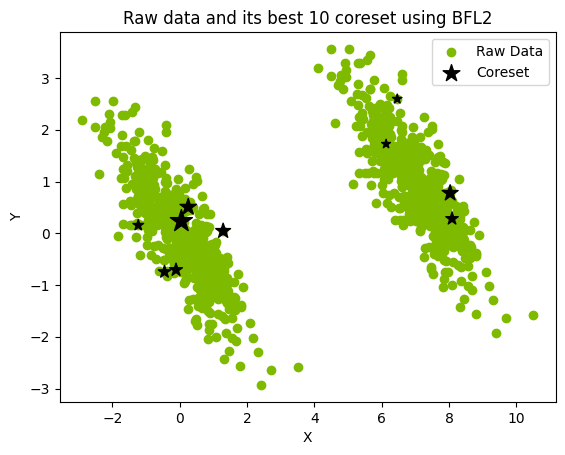

In [5]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], label="Raw Data", c="#7eba00")
plt.scatter(
    coreset_df["X"],
    coreset_df["Y"],
    s=coreset_df["weights"],
    label="Coreset",
    color="black",
    marker="*",
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best 10 coreset using BFL2")
plt.legend()
plt.show()

### Data Preprocessing

To cluster data on a quantum computer, the task needs to be cast into the form of a binary optimization problem. Each qubit represents a coreset point, and the quantum algorithm determines how to bipartition the coreset points at each iteration of the divisive clustering routine.

The first step is to convert coreset points into a fully connected graph. The edge weight is calculated by:

\[ w_{ij} = \| x_i - x_j \| \]

where \( \| x_i - x_j \| \) is the Euclidean distance between points \( x_i \) and \( x_j \).

This process is handled by `Coreset.coreset_to_graph()`. The function returns a fully connected graph \( G \) with edge weights.

### Quantum Functions

The divisive clustering problem will be implemented on a quantum computer using a Variational Quantum Algorithm (VQA) approach. A VQA takes a Hamiltonian (encoded with the optimization problem) and a parameterized ansatz, and evaluates expectation values (on a quantum computer) that inform updates to the ansatz parameters (on a classical computer). The graph (code in the `src` file) is used to construct the Hamiltonian, derived specifically for the divisive clustering problem and motivated by a max-cut Hamiltonian. The `spin.z(i)` method in CUDA-Q adds a Pauli Z operation that acts on qubit \(i\) to the Hamiltonian.

In [6]:
def get_K2_Hamiltonian(G: nx.Graph) -> cudaq.SpinOperator:
    """Returns the K2 Hamiltonian for the given graph G

    Args:
        G (nx.Graph): Weighted graph
    """
    H = 0

    for i, j in G.edges():
        weight = G[i][j]["weight"]
        H += weight * (spin.z(i) * spin.z(j))

    return H

The code below constructs a quantum kernel, defining the circuit which will serve as an ansatz. The structure of the circuit is a hardware-efficient ansatz consisting of layers of parameterized \( R_y \) and \( R_z \) gates acting on each qubit, followed by a linear cascade of CNOT gates, and two more rotation gates.

The `@cudaq.kernel` decorator allows us to define a quantum circuit in the new kernel mode syntax, which provides performance benefits through JIT compilation.

In [7]:
def get_VQE_circuit(number_of_qubits: int, circuit_depth: int) -> cudaq.Kernel:
    """Returns the VQE circuit for the given number of qubits and circuit depth

    Args:
        number_of_qubits (int): Number of qubits
        circuit_depth (int): Circuit depth

    Returns:
        cudaq.Kernel: VQE Circuit
    """

    @cudaq.kernel
    def kernel(thetas: list[float], number_of_qubits: int, circuit_depth: int):
        """VQE Circuit

        Args:
            thetas (list[float]): List of parameters
            number_of_qubits (int): Number of qubits
            circuit_depth (int): Circuit depth
        """
        qubits = cudaq.qvector(number_of_qubits)

        theta_position = 0

        for i in range(circuit_depth):
            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

            for j in range(number_of_qubits - 1):
                cx(qubits[j], qubits[j + 1])

            for j in range(number_of_qubits):
                ry(thetas[theta_position], qubits[j])
                rz(thetas[theta_position + 1], qubits[j])

                theta_position += 2

    return kernel

We can visualize the circuit using the cudaq.draw() method. Below, we are drawing the circuit for 5 qubits.

In [8]:
parameter_count = 4 * circuit_depth * 5
parameters = np.random.rand(parameter_count)

circuit = get_VQE_circuit(5, circuit_depth)
print(cudaq.draw(circuit, parameters, 5, circuit_depth))

     ╭────────────╮╭────────────╮     ╭────────────╮╭────────────╮»
q0 : ┤ ry(0.7442) ├┤ rz(0.1862) ├──●──┤ ry(0.8638) ├┤ rz(0.1269) ├»
     ├────────────┤├───────────┬╯╭─┴─╮╰────────────╯├────────────┤»
q1 : ┤ ry(0.4138) ├┤ rz(0.231) ├─┤ x ├──────●───────┤ ry(0.3709) ├»
     ├────────────┤├───────────┴╮╰───╯    ╭─┴─╮     ╰────────────╯»
q2 : ┤ ry(0.6536) ├┤ rz(0.7644) ├─────────┤ x ├───────────●───────»
     ├────────────┤├────────────┤         ╰───╯         ╭─┴─╮     »
q3 : ┤ ry(0.8349) ├┤ rz(0.2122) ├───────────────────────┤ x ├─────»
     ├───────────┬╯├────────────┤                       ╰───╯     »
q4 : ┤ ry(0.962) ├─┤ rz(0.2611) ├─────────────────────────────────»
     ╰───────────╯ ╰────────────╯                                 »

################################################################################

                                           
───────────────────────────────────────────
╭────────────╮                             
┤ rz(0.6719) ├───────────────────────

The next step is to select a classical optimizer. CUDA-Q provides multiple built-in optimizers. The code below returns the optimizer with the appropriate number of initial parameters.

In [10]:
def get_optimizer(optimizer: cudaq.optimizers.optimizer, max_iterations,
                  **kwargs) -> Tuple[cudaq.optimizers.optimizer, int]:
    """Returns the optimizer with the given parameters

    Args:
        optimizer (cudaq.optimizers.optimizer): Optimizer
        max_iterations (int): Maximum number of iterations
        **kwargs: Additional arguments

    Returns:
        tuple(cudaq.optimizers.optimizer, int): Optimizer and parameter count
    """
    parameter_count = 4 * kwargs["circuit_depth"] * kwargs["qubits"]
    initial_params = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                       parameter_count)
    optimizer.initial_parameters = initial_params

    optimizer.max_iterations = max_iterations
    return optimizer, parameter_count

### Divisive Clustering Function

The `DivisiveClusteringVQA` class enables the procedure to iteratively bipartition the coreset points until each is its own cluster. If you wish to develop on top of this or see how the underlying code works, please see the `divisive_clustering.py` file in the `src` directory.

`run_divisive_clustering` takes the current iteration’s coreset points that will be bipartitioned as inputs, extracts the appropriate weights, and builds a graph. The graph is then an input into the `get_counts_from_simulation` function.

`get_counts_from_simulation` handles the preparation and execution of the quantum simulation. First, it takes the graph and from it builds a spin Hamiltonian. Second, it defines a cost function, which in this case is a lambda function that returns the expectation value of our parameterized quantum circuit and the Hamiltonian. This value is obtained using the CUDA-Q `observe` command, accelerated by GPUs. After the expectation value is minimized, the quantum circuit corresponding to the optimal parameters is sampled using the CUDA-Q `sample` function. The bitstrings and their associated counts are returned by `get_counts_from_simulation`.

A subset of these counts is evaluated to compute their exact cost. The best bitstring is returned and later used to assign the coreset points to one of two clusters.

In [11]:
class DivisiveClusteringVQA(DivisiveClustering):
    
    def __init__(
        self,
        **kwargs,
    ):
        super().__init__(**kwargs)

    def run_divisive_clustering(
        self,
        coreset_vectors_df_for_iteration: pd.DataFrame,
    ):
        """Runs the Divisive Clustering algorithm

        Args:
            coreset_vectors_df_for_iteration (pd.DataFrame): Coreset vectors for the iteration

        Returns:
            str: Best bitstring

        """
        coreset_vectors_for_iteration_np, coreset_weights_for_iteration_np = (
            self._get_iteration_coreset_vectors_and_weights(
                coreset_vectors_df_for_iteration))

        G = Coreset.coreset_to_graph(
            coreset_vectors_for_iteration_np,
            coreset_weights_for_iteration_np,
            metric=self.coreset_to_graph_metric,
        )

        counts = self.get_counts_from_simulation(
            G,
            self.circuit_depth,
            self.max_iterations,
            self.max_shots,
        )

        return self._get_best_bitstring(counts, G)

    def get_counts_from_simulation(self, G: nx.graph, circuit_depth: int,
                                   max_iterations: int,
                                   max_shots: int) -> cudaq.SampleResult:
        """
        Runs the VQA simulation

        Args:
            G (nx.graph): Graph
            circuit_depth (int): Circuit depth
            max_iterations (int): Maximum number of iterations
            max_shots (int): Maximum number of shots

        Returns:
            cudaq.SampleResult: Measurement from the experiment
        """

        qubits = len(G.nodes)
        Hamiltonian = self.create_Hamiltonian(G)
        optimizer, parameter_count = self.optimizer_function(
            self.optimizer,
            max_iterations,
            qubits=qubits,
            circuit_depth=circuit_depth)

        kernel = self.create_circuit(qubits, circuit_depth)

        def objective_function(
            parameter_vector: list[float],
            hamiltonian: cudaq.SpinOperator = Hamiltonian,
            kernel: cudaq.Kernel = kernel,
        ) -> float:
            """

            Objective function that returns the cost of the simulation

            Args:
                parameter_vector (List[float]):
                hamiltonian (cudaq.SpinOperator): Circuit parameter values as a vector
                kernel (cudaq.Kernel) : Circuit configuration

            Returns:
                float: Expectation value of the circuit

            """

            get_result = lambda parameter_vector: cudaq.observe(
                kernel, hamiltonian, parameter_vector, qubits, circuit_depth
            ).expectation()

            cost = get_result(parameter_vector)

            return cost

        energy, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_function)

        counts = cudaq.sample(kernel,
                              optimal_parameters,
                              qubits,
                              circuit_depth,
                              shots_count=max_shots)

        return counts

An instance of the `DivisiveClusteringVQA` class is primarily constructed using previously discussed variables, such as functions for building Hamiltonians and quantum circuits. Parameters related to the quantum simulation, such as `circuit_depth` and `max_shots`, can also be specified. The `threshold_for_max_cut` parameter determines the percentage of sample results from the quantum computer that are evaluated for the best bitstring value.

Additional options include advanced features like data normalization and methods for computing graph weights.

The `get_divisive_sequence` method performs the iterations and generates the clustering data, which we will analyze below. Note that this postprocessing code is not detailed in this tutorial but can be found in the source code.

In [12]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence = divisive_clustering.get_divisive_sequence(
    coreset_df)

100%|██████████| 3/3 [00:00<00:00, 30690.03it/s]


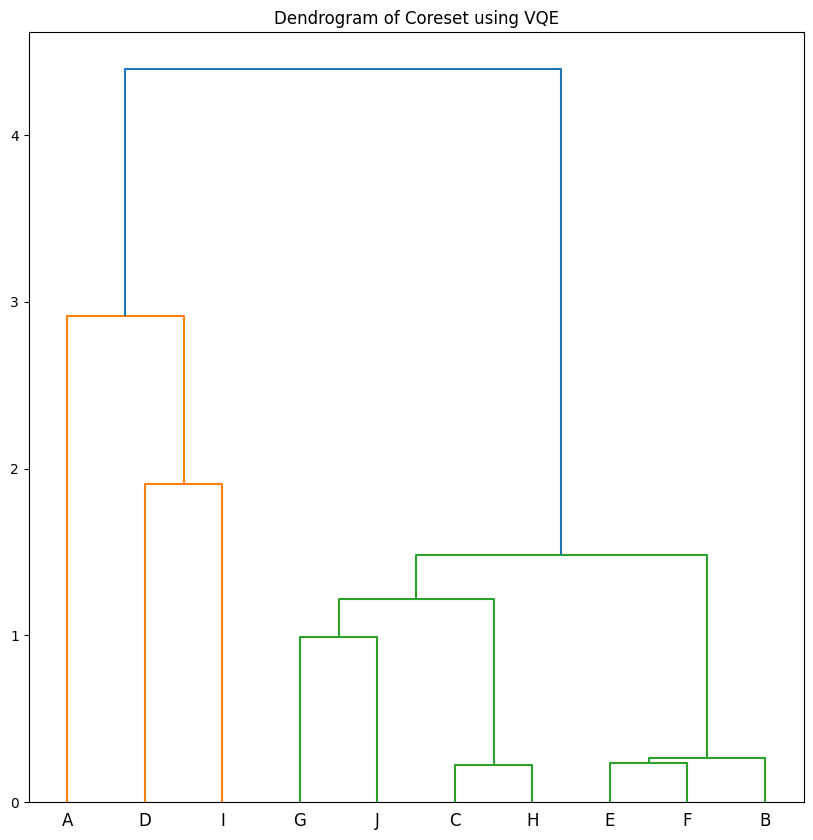

In [13]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence)
dendo.plot_dendrogram(plot_title="Dendrogram of Coreset using VQE")

Each branch point in the dendrogram above corresponds to one of the plots below. Notice that the initial iterations are the most complex, while the final iterations involve trivial bipartitioning of two points. Occasionally, especially in the first iteration, the partitioning might seem puzzling. The data might appear to naturally cluster into two groups, but sometimes a stray point seems to belong to the wrong cluster. There are two possible explanations for this:

1. The quantum sampling is approximate and stochastic. It is possible that too few shots were taken to sample the ground state of the problem accurately.
2. Remember that we are clustering coresets, not individual data points. In some cases, it might be optimal to pay a penalty by excluding a point based on proximity if the weights are small enough that the penalty has less impact. Usually, if a point appears unusually clustered, checking the original coresets plotted above will reveal that the point has a small weight.

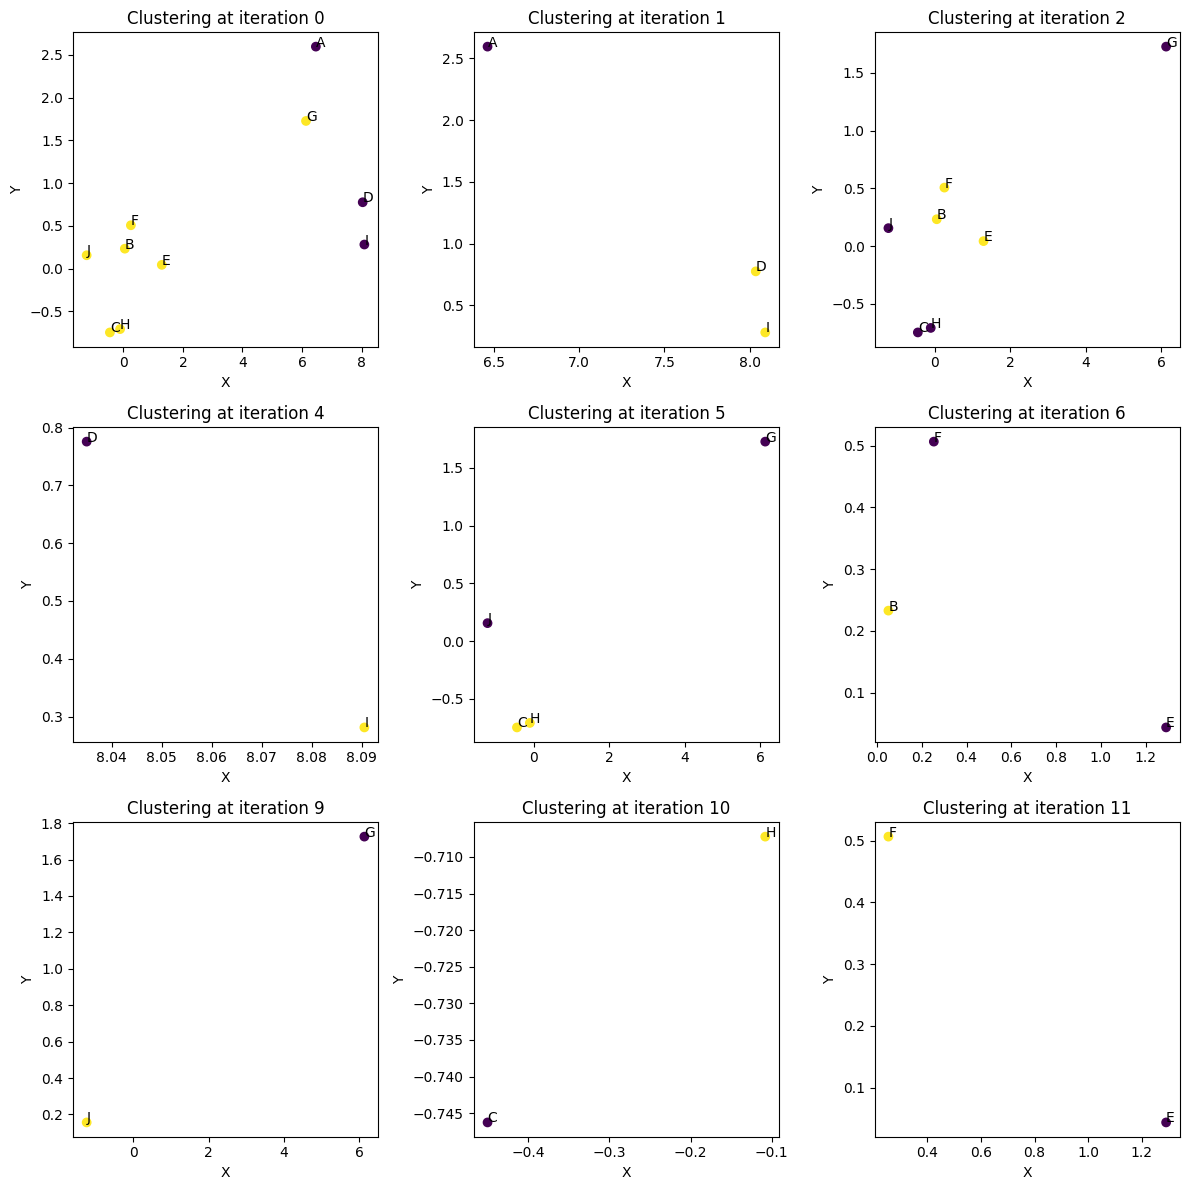

In [14]:
Dendrogram.plot_hierarchial_split(hierarchial_clustering_sequence, coreset_df)

The hierarchical clustering can be converted to flat clustering by drawing a line perpendicular to the branches. Any data point that intersects the line is considered to be in the same cluster. The function below performs this task at a threshold height of 1.5. If you want to use the number of clusters instead of height, you can use the `dendo.get_clusters_using_k()` method. Pass the number of desired clusters as an argument. The figure below shows the clusters formed at a threshold height of 1.5.

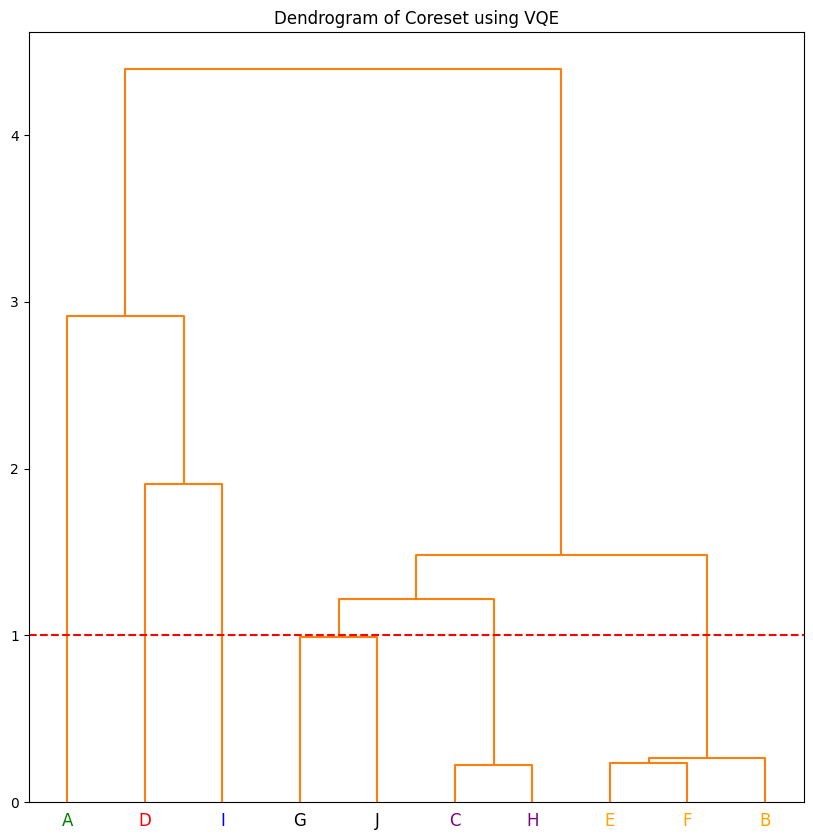

In [15]:
threshold_height = 1
clusters = dendo.get_clusters_using_height(threshold_height)
colors = ["red", "blue", "green", "black", "purple", "orange", "yellow"]
dendo.plot_dendrogram(
    plot_title="Dendrogram of Coreset using VQE",
    colors=colors,
    clusters=clusters,
    color_threshold=threshold_height,
)

We can visualize the flat clusters using dendo.plot_clusters() method. The function takes the clusters and colors as arguments. The clusters are represented by different colors.

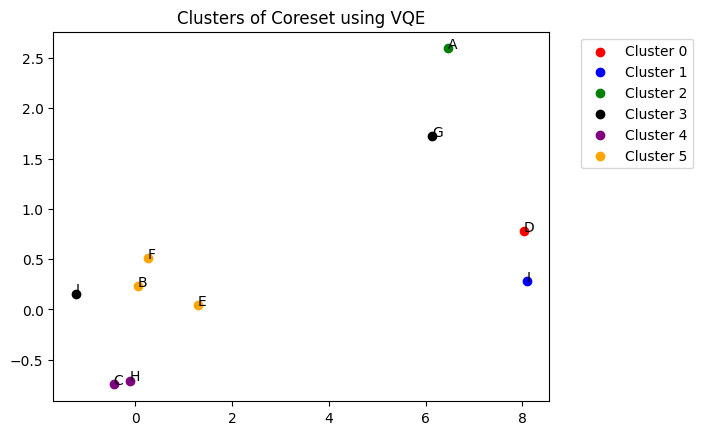

In [16]:
dendo.plot_clusters(clusters,
                    colors,
                    plot_title="Clusters of Coreset using VQE",
                    show_annotation=True)

The function below uses the `dendo.get_voronoi_tessalation()` method to convert the clusters into regions. `coreset_df`, `clusters`, and `colors` need to be passed as arguments to create the regions. This function creates a region for each coreset point separately and then colors them according to the clusters with colors passed as arguments. Another option is to create regions using the centroids of the clusters. You need to pass `tesslation_by_cluster=True` to the function to perform this task.

Once the region creation is complete, you can use the `plot_voironi()` method to plot the regions. The function takes the clusters and colors as arguments.

Remembering that these regions were based on coresets, they can overlay the original data set and be used to cluster the data based on the coreset analysis.

In [17]:
vt = Voironi_Tessalation(coreset_df,
                         clusters,
                         colors,
                         tesslation_by_cluster=False)
vt.plot_voironi(plot_title="Voironi Tessalation of Coreset using VQE",
                show_annotation=True)

AttributeError: `ptp` was removed from the ndarray class in NumPy 2.0. Use np.ptp(arr, ...) instead.

### QAOA Implementation

CUDA-Q is designed to be a flexible tool for developers so they can test different implementations of the same code. For example, one can perform the same analysis, instead using a QAOA approach. Only the kernel needs to be changed as is done below.

In [18]:
def get_QAOA_circuit(number_of_qubits, circuit_depth) -> cudaq.Kernel:
    """Returns the QAOA circuit for the given number of qubits and circuit depth


    Args:
        number_of_qubits (int): Number of qubits
        circuit_depth (int): Circuit depth

    Returns:
        cudaq.Kernel: QAOA Circuit
    """

    @cudaq.kernel
    def kernel(thetas: list[float], number_of_qubits: int, circuit_depth: int):
        qubits = cudaq.qvector(number_of_qubits)

        layers = circuit_depth

        for layer in range(layers):
            for qubit in range(number_of_qubits):
                cx(qubits[qubit], qubits[(qubit + 1) % number_of_qubits])
                rz(2.0 * thetas[layer], qubits[(qubit + 1) % number_of_qubits])
                cx(qubits[qubit], qubits[(qubit + 1) % number_of_qubits])

            rx(2.0 * thetas[layer + layers], qubits)

    return kernel


circuit = get_QAOA_circuit(5, circuit_depth)

print(cudaq.draw(circuit, np.random.rand(2 * circuit_depth), 5, circuit_depth))

                                                                »
q0 : ──●─────────────────────●──────────────────────────────────»
     ╭─┴─╮╭───────────────╮╭─┴─╮                                »
q1 : ┤ x ├┤ rz(0.0002127) ├┤ x ├──●─────────────────────●───────»
     ╰───╯╰───────────────╯╰───╯╭─┴─╮╭───────────────╮╭─┴─╮     »
q2 : ───────────────────────────┤ x ├┤ rz(0.0002127) ├┤ x ├──●──»
                                ╰───╯╰───────────────╯╰───╯╭─┴─╮»
q3 : ──────────────────────────────────────────────────────┤ x ├»
                                                           ╰───╯»
q4 : ───────────────────────────────────────────────────────────»
                                                                »

################################################################################

                                                 ╭───╮╭───────────────╮╭───╮»
─────────────────────────────────────────────────┤ x ├┤ rz(0.0002127) ├┤ x ├»
                                   

In [20]:
def get_optimizer(optimizer: cudaq.optimizers.optimizer, max_iterations,
                  **kwargs) -> Tuple[cudaq.optimizers.optimizer, int]:
    """
    Returns the optimizer with the given parameters

    Args:
        optimizer (cudaq.optimizers.optimizer): Optimizer
        max_iterations (int): Maximum number of iterations
        **kwargs: Additional arguments

    Returns:
        tuple(cudaq.optimizers.optimizer, int): Optimizer and parameter count
    """

    parameter_count = 2 * kwargs["circuit_depth"]
    optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                     parameter_count)
    optimizer.max_iterations = max_iterations
    return optimizer, parameter_count

In [21]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer,
    create_circuit=get_QAOA_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence = divisive_clustering.get_divisive_sequence(
    coreset_df)

100%|██████████| 4/4 [00:00<00:00, 51781.53it/s]


### Scaling Simulations with CUDA-Q

The University of Edinburgh team quickly encountered scaling challenges when developing this method. By using CUDA-Q, they were able to port their code to an HPC environment once GPUs became available. GPUs massively accelerated their development and testing, allowing them to produce the 25 qubit experiments presented in their publication. If you have a GPU available, run the following code examples and see how the times compare on your device. Each call executes the divisive clustering procedure using the QAOA method, with 100,000 simulated shots for each VQE loop and a maximum of 75 VQE iterations.
First, try a slightly larger \( N=18 \) problem using the CPU (qpp-cpu) backend.

In [22]:
# Uncomment the following line if you want to explicitly execute this step on your system.
# !python3 divisive_clustering_src/main_divisive_clustering.py --target qpp-cpu --M 18

In [23]:
!python3 divisive_clustering_src/main_divisive_clustering.py --target nvidia --M 18

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[UOL-PBWS1004455:250485] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.UOL-PBWS1004455.1000/jf.0/1378418688/shared_mem_cuda_pool.UOL-PBWS1004455 could be created.
[UOL-PBWS1004455:250485] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
Using BFL2 method to generate coresets
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 72628.64it/s]
Total time for the execution: 1.676071799999999
Total time spent on CUDA-Q: 1.2424905000000006


Scaling up to N=25, the task becomes even more onerous on a CPU. Depending on your device, the simulation may not even run. Try it and feel free to interrupt after your patience has worn out.

In [24]:
# target = 'qpp-cpu'
# Uncomment the following line if you want to explicitly execute this step on your system.
# !python3 divisive_clustering_src/main_divisive_clustering.py --target qpp-cpu --M 25

In [25]:
# target = 'nvidia'
!python3 divisive_clustering_src/main_divisive_clustering.py --target nvidia --M 25

/bin/bash: /home/ryukijano/miniconda3/envs/cuda-quantum/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[UOL-PBWS1004455:250871] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.UOL-PBWS1004455.1000/jf.0/4291624960/shared_mem_cuda_pool.UOL-PBWS1004455 could be created.
[UOL-PBWS1004455:250871] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
Using BFL2 method to generate coresets
100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 71697.50it/s]
Total time for the execution: 12.8259506
Total time spent on CUDA-Q: 8.149675300000002


If we want to push the simulation to an N = 34
 coreset, a single GPU (assuming A100) will run out of memory. Run the code below to see for yourself.

In [ ]:
# target = 'nvidia'
!python3 divisive_clustering_src/main_divisive_clustering.py --target nvidia --M 34

To compute a problem with 34 qubits, we need to pool the memory of multiple GPUs. If you have multiple GPUs available, try the code below to run the same computation on 4 GPUs. You do not need to wait for the code to finish, just note how it does not fail immediately due to memory issues

In [ ]:
# target = 'nvidia-mgpu'
gpu_count = !nvidia-smi -L | wc -l
try:
    gpu_count = int(gpu_count[0])
except:
    gpu_count = 0
if gpu_count >= 4:
    !mpirun -np 4 python3 divisive_clustering_src/main_divisive_clustering.py --target nvidia-mgpu --M 34
else:
    print(
        f'Not enough GPUs found on this system ({gpu_count}) to run this step')